In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [86]:
# Load & Clean Data
df = pd.read_csv('2015-building-energy-benchmarking.csv')
df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True)
df.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,...,GHGEmissionsIntensitykgCO2eft2,DefaultData,Comment,ComplianceStatus,Outlier,2010CensusTracts,SeattlePoliceDepartmentMicroCommunityPolicingPlanAreas,CityCouncilDistricts,SPDBeats,ZipCodes
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,"{'latitude': '47.61219025', 'longitude': '-122...",7,DOWNTOWN,1927,...,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,"{'latitude': '47.61310583', 'longitude': '-122...",7,DOWNTOWN,1996,...,2.38,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,"{'latitude': '47.61334897', 'longitude': '-122...",7,DOWNTOWN,1969,...,1.92,Yes,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,18081
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,"{'latitude': '47.61421585', 'longitude': '-122...",7,DOWNTOWN,1926,...,31.38,No,NaN,Compliant,High Outlier,NaN,56.0,NaN,31.0,18081
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,"{'latitude': '47.6137544', 'longitude': '-122....",7,DOWNTOWN,1980,...,4.02,No,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,19576


In [87]:
columns_to_drop = ['OSEBuildingID', 'PropertyName', 'TaxParcelIdentificationNumber', 'Location','ListOfAllPropertyUseTypes', 'Comment', 'Outlier']
df = df.drop(columns=columns_to_drop, errors='ignore')

In [88]:
df['DataYear'] = pd.to_numeric(df['DataYear'], errors='coerce')
df['YearBuilt'] = pd.to_numeric(df['YearBuilt'], errors='coerce')
df['NumberofFloors'] = pd.to_numeric(df['NumberofFloors'], errors='coerce')
df['BuildingAge'] = 2025 - df['YearBuilt']

In [89]:
df = df.dropna(subset=['BuildingAge', 'SiteEUIkBtusf', 'NumberofFloors'])

In [90]:
# Basic Statistics
print("\n📊 Basic Dataset Statistics:")
print("These basic stats give an overview of key numeric fields.")
print(df.describe())
print("\n🔎 Insight: This table helps us understand ranges, averages, and potential data issues (like extreme outliers).")


📊 Basic Dataset Statistics:
These basic stats give an overview of key numeric fields.
       DataYear  CouncilDistrictCode    YearBuilt  NumberofBuildings  \
count    3322.0          3322.000000  3322.000000        3322.000000   
mean     2015.0             4.455750  1967.676099           1.031306   
std         0.0             2.128229    32.969156           0.764057   
min      2015.0             1.000000  1900.000000           1.000000   
25%      2015.0             3.000000  1947.000000           1.000000   
50%      2015.0             4.000000  1974.000000           1.000000   
75%      2015.0             7.000000  1996.000000           1.000000   
max      2015.0             7.000000  2015.000000          39.000000   

       NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
count     3322.000000      3.322000e+03         3322.000000   
mean         4.690247      9.075498e+04        11112.081577   
std          5.464409      1.494017e+05        35382.866817   
min         

In [111]:
# Cleaned dataset
print("Cleaned Dataset")
df.head()

Cleaned Dataset


,DataYear,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,...,GHGEmissionsIntensitykgCO2eft2,DefaultData,ComplianceStatus,2010CensusTracts,SeattlePoliceDepartmentMicroCommunityPolicingPlanAreas,CityCouncilDistricts,SPDBeats,ZipCodes,BuildingAge,anomaly
0,2015,NonResidential,Hotel,7,DOWNTOWN,1927,1,12.0,88434,0,...,2.64,No,Compliant,NaN,14.0,NaN,31.0,18081,98,Normal
1,2015,NonResidential,Hotel,7,DOWNTOWN,1996,1,11.0,103566,15064,...,2.38,No,Compliant,NaN,14.0,NaN,31.0,18081,29,Normal
2,2015,NonResidential,Hotel,7,DOWNTOWN,1969,1,41.0,961990,0,...,1.92,Yes,Compliant,NaN,56.0,NaN,31.0,18081,56,Normal
3,2015,NonResidential,Hotel,7,DOWNTOWN,1926,1,10.0,61320,0,...,31.38,No,Compliant,NaN,56.0,NaN,31.0,18081,99,Anomaly
4,2015,NonResidential,Hotel,7,DOWNTOWN,1980,1,18.0,119890,12460,...,4.02,No,Compliant,NaN,56.0,NaN,31.0,19576,45,Normal



📈 Distribution of Energy Intensity (EUI)


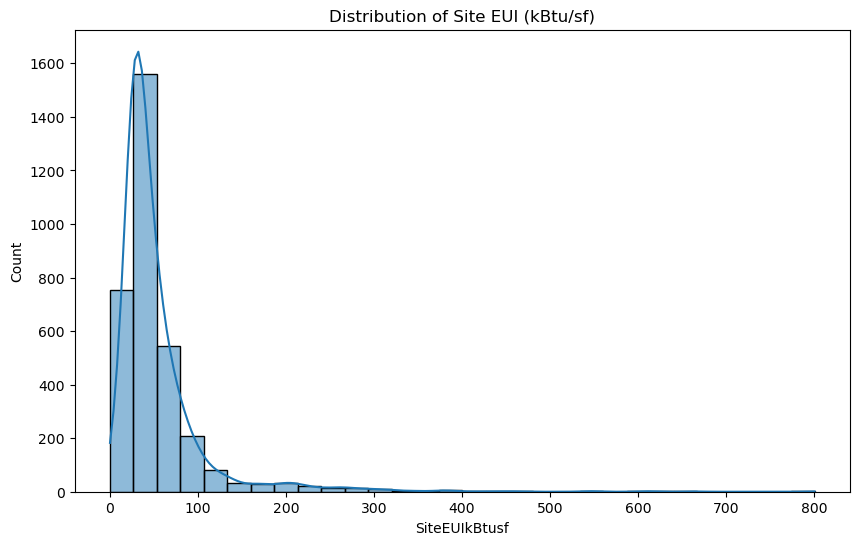


🔎 Insight: This plot shows most buildings have moderate energy intensity, but some extreme outliers exist — we’ll need to address that later.


In [92]:
# Distribution Plot
plt.figure(figsize=(10, 6))
sns.histplot(df['SiteEUIkBtusf'], bins=30, kde=True)
plt.title('Distribution of Site EUI (kBtu/sf)')
print("\n📈 Distribution of Energy Intensity (EUI)")
plt.show()
print("\n🔎 Insight: This plot shows most buildings have moderate energy intensity, but some extreme outliers exist — we’ll need to address that later.")

In [93]:
# # Correlation Heatmap
# plt.figure(figsize=(12, 8))
# sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
# plt.title('Correlation Heatmap')
# print("\n📌 Correlation Heatmap")
# plt.show()
# print("\n🔎 Insight: This heatmap highlights relationships between variables. For example, we can see how building age, floors, and size correlate with energy use — crucial for selecting model features.")

In [94]:
# Anomaly Detection (Z-score Method)
df['z_score'] = stats.zscore(df['SiteEUIkBtusf'])
df['anomaly'] = df['z_score'].apply(lambda x: 'Anomaly' if abs(x) > 3 else 'Normal')


🚨 Anomalies in Energy Use:


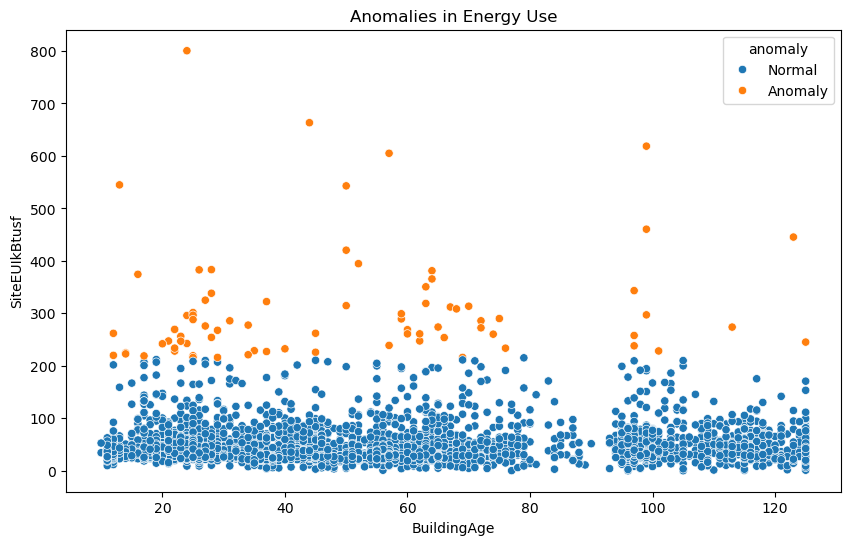


🔎 Insight: This scatterplot highlights buildings with unusual energy use. Spotting these helps detect errors or operational inefficiencies for targeted investigation.


In [95]:
print("\n🚨 Anomalies in Energy Use:")
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['BuildingAge'], y=df['SiteEUIkBtusf'], hue=df['anomaly'])
plt.title('Anomalies in Energy Use')
plt.show()
print("\n🔎 Insight: This scatterplot highlights buildings with unusual energy use. Spotting these helps detect errors or operational inefficiencies for targeted investigation.")

In [96]:
df.drop(columns=['z_score'], inplace=True)

In [97]:
# Trend Analysis
yearly_trend = df.groupby('DataYear')['SiteEUIkBtusf'].mean().reset_index()

In [98]:
# Correlation Analysis
correlations = df.corr(numeric_only=True)['SiteEUIkBtusf'].sort_values(ascending=False)

In [99]:
print("\n🔗 Top Correlations with Energy Intensity:")
print(correlations)
print("\n🔎 Insight: These correlations show which factors (like size, age, floors) have the strongest influence on energy use. These are our priority features for prediction models and efficiency programs.")



🔗 Top Correlations with Energy Intensity:
SiteEUIkBtusf                                             1.000000
SiteEUIWNkBtusf                                           0.995961
SourceEUIWNkBtusf                                         0.953006
SourceEUIkBtusf                                           0.950739
GHGEmissionsIntensitykgCO2eft2                            0.721175
SiteEnergyUseWNkBtu                                       0.451656
SiteEnergyUsekBtu                                         0.451310
ElectricitykBtu                                           0.440151
ElectricitykWh                                            0.440151
GHGEmissionsMetricTonsCO2e                                0.360453
NaturalGaskBtu                                            0.348101
NaturalGastherms                                          0.348101
SteamUsekBtu                                              0.136934
PropertyGFATotal                                          0.107163
PropertyGFABuilding

In [100]:
# Cluster Analysis
cluster_data = df[['SiteEUIkBtusf', 'BuildingAge', 'NumberofFloors']].dropna()
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data)

In [101]:
# Using K-means
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_data['Cluster'] = kmeans.fit_predict(scaled_data)


🏢 Building Clusters by Energy Behavior:


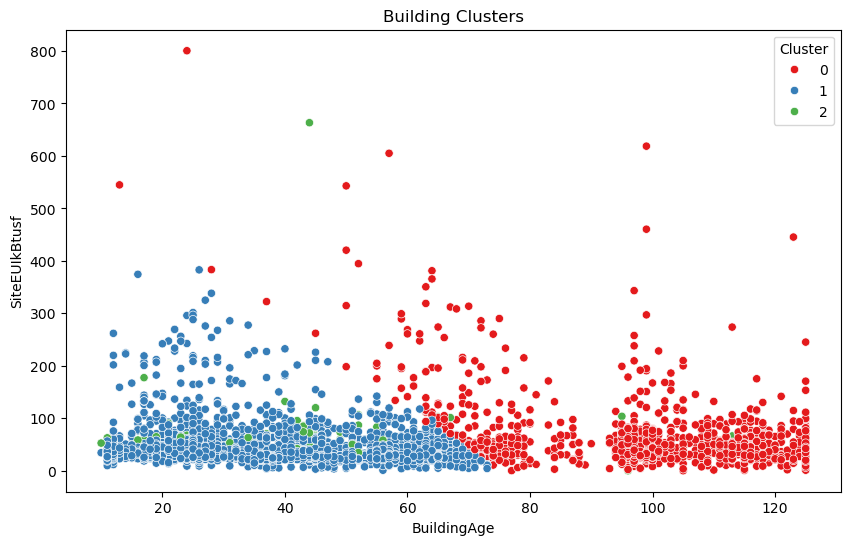


🔎 Insight: Clustering groups buildings with similar age and energy behavior. Each group could need different management strategies, like retrofits for older buildings or monitoring newer ones.


In [102]:
print("\n🏢 Building Clusters by Energy Behavior:")
plt.figure(figsize=(10, 6))
sns.scatterplot(x=cluster_data['BuildingAge'], y=cluster_data['SiteEUIkBtusf'], hue=cluster_data['Cluster'], palette='Set1')
plt.title('Building Clusters')
plt.show()
print("\n🔎 Insight: Clustering groups buildings with similar age and energy behavior. Each group could need different management strategies, like retrofits for older buildings or monitoring newer ones.")

In [103]:
# Predictive Model - Linear Regression
features = ['BuildingAge', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFABuildings']
X = df[features].fillna(0)
y = df['SiteEUIkBtusf']

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [105]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [106]:
print("\n🤖 Predicting Energy Usage - Model Performance:")
print(f"RMSE (Root Mean Squared Error): {mean_squared_error(y_test, y_pred, squared=False):.2f}")
print(f"R2 Score (Model Fit Quality): {r2_score(y_test, y_pred)}:.2f")
print("\n🔎 Insight: RMSE measures average prediction error (lower is better), and R2 shows how well our model fits the data (closer to 1 is ideal). This gives us a sense of how reliable our predictions are.")


🤖 Predicting Energy Usage - Model Performance:
RMSE (Root Mean Squared Error): 56.70
R2 Score (Model Fit Quality): 0.001989752372482667:.2f

🔎 Insight: RMSE measures average prediction error (lower is better), and R2 shows how well our model fits the data (closer to 1 is ideal). This gives us a sense of how reliable our predictions are.


C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [107]:
# Recommendations
print("\n📚 Recommendations for Energy Efficiency:")
print("🔎 Based on all our analysis, here’s how building managers can act:")
print("""
1️⃣ Focus retrofitting efforts on older buildings (higher energy intensity).
2️⃣ Encourage taller buildings where feasible — more floors tend to be more efficient.
3️⃣ Investigate anomalies — these buildings might have maintenance issues or data errors.
4️⃣ Use this model to forecast energy needs during building design and renovation.
5️⃣ For future improvements, add weather and occupancy data to refine predictions.
6️⃣ Adopt smart building tech for real-time energy optimization.
7️⃣ Customize strategies for each building cluster (older, high-use, low-use, etc.).
8️⃣ Set energy reduction targets for the worst-performing clusters.
""")
print("\n✅ Conclusion: Combining data analysis, clustering, prediction, and anomaly detection gives building managers a full toolkit to reduce energy waste and improve sustainability.")



📚 Recommendations for Energy Efficiency:
🔎 Based on all our analysis, here’s how building managers can act:

1️⃣ Focus retrofitting efforts on older buildings (higher energy intensity).
2️⃣ Encourage taller buildings where feasible — more floors tend to be more efficient.
3️⃣ Investigate anomalies — these buildings might have maintenance issues or data errors.
4️⃣ Use this model to forecast energy needs during building design and renovation.
5️⃣ For future improvements, add weather and occupancy data to refine predictions.
6️⃣ Adopt smart building tech for real-time energy optimization.
7️⃣ Customize strategies for each building cluster (older, high-use, low-use, etc.).
8️⃣ Set energy reduction targets for the worst-performing clusters.


✅ Conclusion: Combining data analysis, clustering, prediction, and anomaly detection gives building managers a full toolkit to reduce energy waste and improve sustainability.
